In [1]:
import sys 
sys.path.append("../models/")
from functions import plot_style
from import_functions import get_averted_deaths
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
colors = plot_style("../fonts/Encode_Sans_Condensed/")

countries = np.array(['Indonesia', 'Bolivia', 'Morocco', 'Bangladesh', 'Sri-Lanka', 'Kenya', 'Mozambique',
                      "Afghanistan", "Cote-dIvoire", "Pakistan", "El-Salvador", "Kyrgyzstan",
                      "Philippines", "Egypt", "Rwanda", "Zambia", "Angola", "Ghana", "Honduras", "Uganda"])

income = {'Indonesia': "LMI", 
          'Bolivia': "LMI", 
          'Morocco': "LMI", 
          'Bangladesh': "LMI", 
          'Sri-Lanka': "LMI", 
          'Kenya': "LMI", 
          'Mozambique': "LI",
          "Afghanistan": "LI", 
          "Cote-dIvoire": "LMI", 
          "Pakistan": "LMI", 
          "El-Salvador": "LMI", 
          "Kyrgyzstan": "LMI",
          "Philippines": "LMI", 
          "Uganda": "LI", 
          "Egypt": "LMI",
          "Rwanda": "LI", 
          "Zambia": "LI", 
          "Angola": 'LMI', 
          "Ghana": "LMI", 
          "Honduras": "LMI"}

end_date = datetime(2021, 10, 1)
vax_start_date = datetime(2020, 12, 14)

who_regions = {'Africa': np.array(["Cote-dIvoire", 'Uganda', 'Ghana', 'Kenya', 'Rwanda', 'Angola', 'Zambia', 'Mozambique']), 
              'Americas': np.array(["El-Salvador","Honduras",'Bolivia']), 
              'Eastern Mediterranean': np.array(['Morocco', 'Egypt', 'Afghanistan', 'Pakistan']), 
              'Europe': np.array(["Kyrgyzstan"]), 
              'South-East Asia': np.array(["Philippines"]), 
              'Western Pacific': np.array(["Bangladesh", 'Sri-Lanka', 'Indonesia'])}

label_match = {"Cote-dIvoire": "Côte d'Ivoire",
               "El-Salvador": "El Salvador",
               "Sri-Lanka": "Sri Lanka"}
for c in countries:
    if c not in label_match.keys():
        label_match[c] = c

# Averted Deaths Respect to Data-Driven Simulation

In [3]:
def import_projections(country, scenario, IQR, baseline='data-driven', path="./projections_october/"):

    # get averted deaths in perc
    avertedDeaths_perc = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=True, path=path)
    avertedDeaths_perc_med = np.median(avertedDeaths_perc)
    if IQR:
        avertedDeaths_perc_q1 = np.quantile(avertedDeaths_perc, q=0.25)
        avertedDeaths_perc_q2 = np.quantile(avertedDeaths_perc, q=0.75)
    else:
        avertedDeaths_perc_q1 = np.quantile(avertedDeaths_perc, q=0.05)
        avertedDeaths_perc_q2 = np.quantile(avertedDeaths_perc, q=0.95)

    # get averted deaths raw (without underreporting multiplier)
    avertedDeaths = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=False, path=path)
    avertedDeaths_med = np.median(avertedDeaths)

    # get averted deaths raw (with underreporting multiplier)
    avertedDeaths_scaled = get_averted_deaths(country, scenario, scaled=True, baseline=baseline, perc=False, path=path)
    avertedDeaths_scaled_med = np.median(avertedDeaths_scaled)

    return avertedDeaths_perc_med, avertedDeaths_perc_q1, avertedDeaths_perc_q2, avertedDeaths_med, avertedDeaths_scaled_med
    

def plot_bar(ax, pos, med, q1, q2, color):
    ax.scatter([pos], [med], color=color, s=100, edgecolor='white', linewidth=0.7, zorder=1, marker="o")
    ax.plot([pos, pos], [q1, q2], color=color, solid_capstyle='round', linewidth=8, alpha=0.5, zorder=-1)


def barplot(ax, scenario, start_i, countries_grp, IQR, baseline='data-driven', path="./projections_october/"):
    # get projections
    avertedDeaths_perc_med, avertedDeaths_perc_q1, avertedDeaths_perc_q2 = np.zeros(len(countries_grp)), np.zeros(len(countries_grp)), np.zeros(len(countries_grp))
    avertedDeaths_med, avertedDeaths_scaled_med = np.zeros(len(countries_grp)), np.zeros(len(countries_grp)) 

    colors_income = []
    for i in range(len(countries_grp)):
        country = countries_grp[i]
        perc_med, perc_q1, perc_q2, med, scaled_med = import_projections(country, scenario, IQR, baseline=baseline, path=path)
        avertedDeaths_perc_med[i] = perc_med
        avertedDeaths_perc_q1[i] = perc_q1
        avertedDeaths_perc_q2[i] = perc_q2
        avertedDeaths_med[i] = med
        avertedDeaths_scaled_med[i] = scaled_med

        if income[country] == "LMI":
            colors_income.append('#DD6E42')
        elif income[country] == "LI":
            colors_income.append('#FFC857')

    # plot  
    idx = np.argsort(avertedDeaths_perc_med)

    for i in range(len(idx)):
        plot_bar(ax, start_i + i, avertedDeaths_perc_med[idx[i]], avertedDeaths_perc_q1[idx[i]], avertedDeaths_perc_q2[idx[i]], colors_income[idx[i]])
        ax.annotate(xy=(start_i + i, avertedDeaths_perc_q2[idx[i]]+2.7), text=str(int(avertedDeaths_med[idx[i]] / 1000)) + "K", size=7, color="grey", ha="center")

    ax.set_ylabel("Averted Deaths (%)",  fontsize=8)    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.grid(True, color='grey', linewidth=0.1, zorder=-1, linestyle="--")
    ax.set_axisbelow(True)
    ax.tick_params(axis="y", labelsize=8)
    
    return countries_grp[idx], avertedDeaths_perc_med

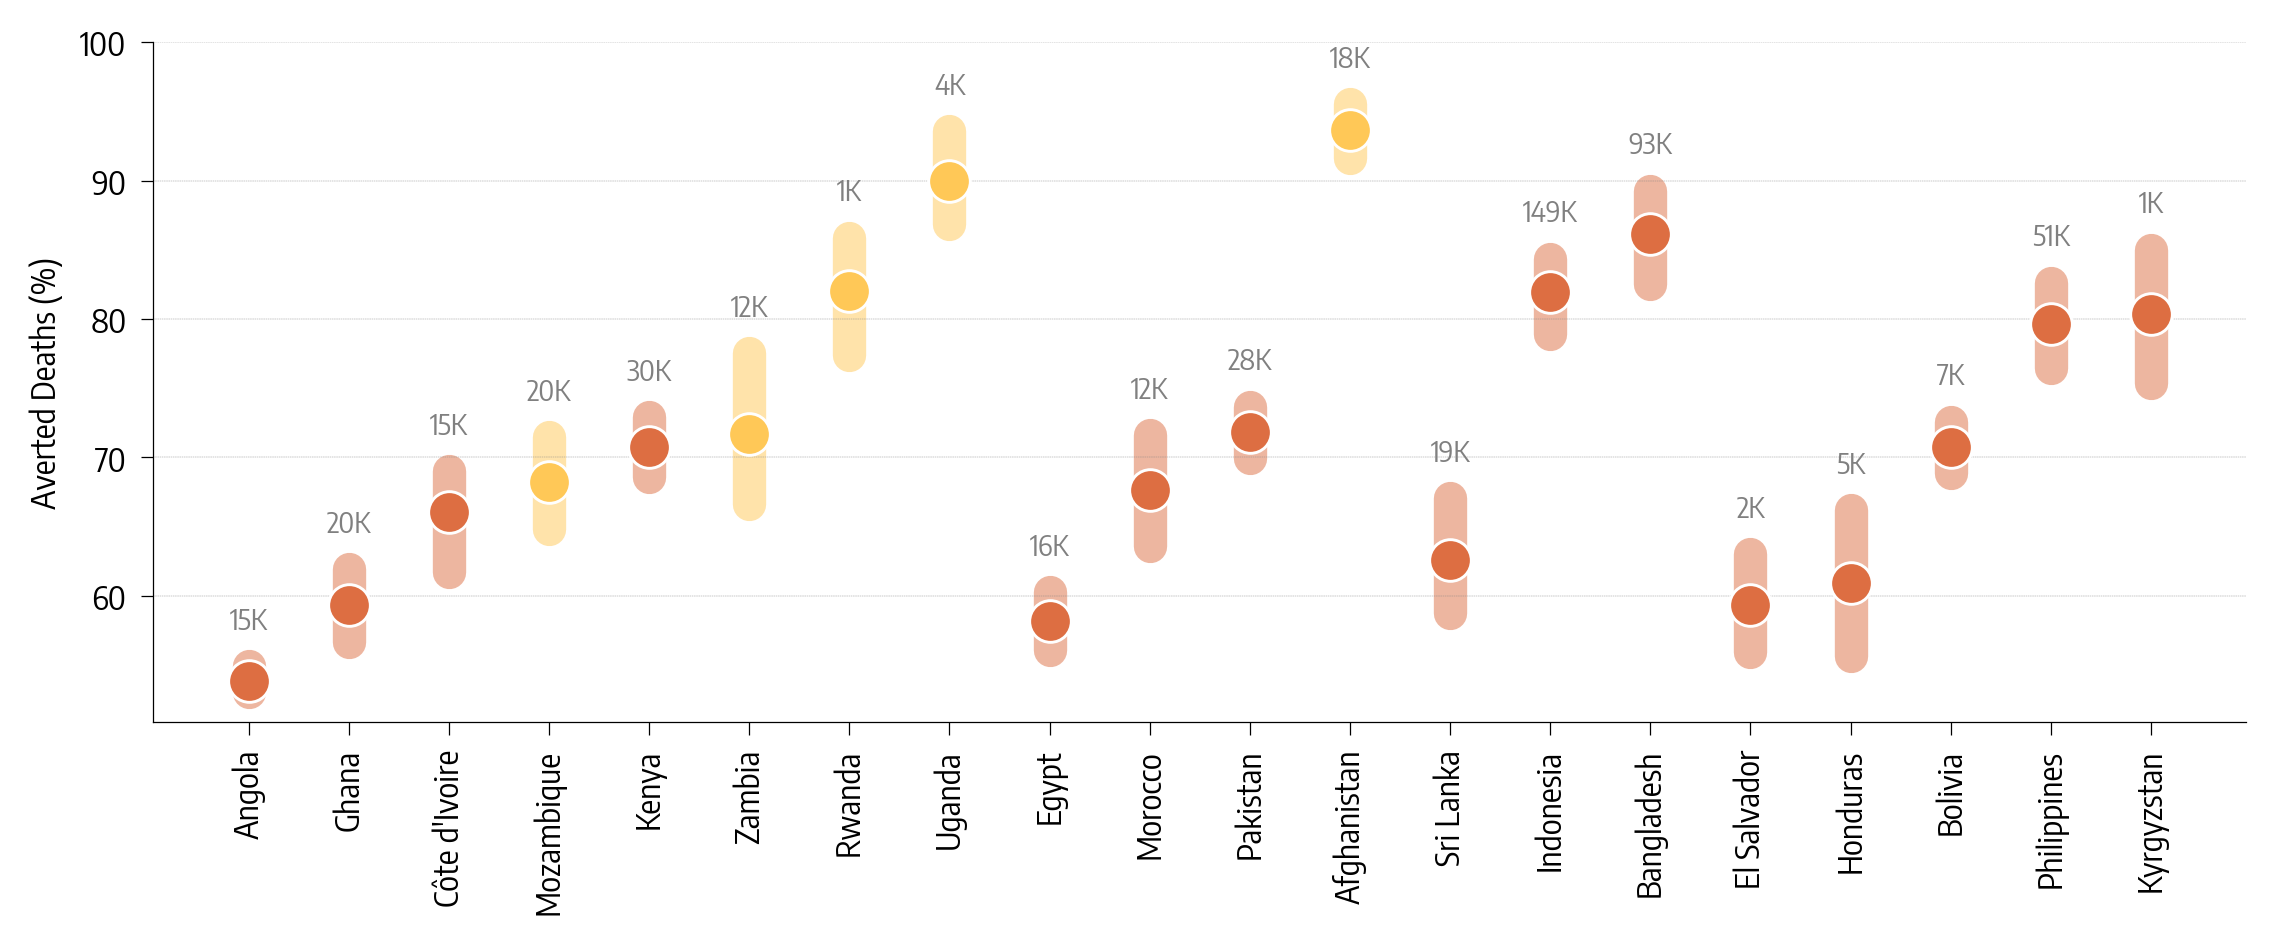

In [4]:
countries_ticks, avertedDeaths_perc_med = [], []
fig, ax = plt.subplots(dpi=300, figsize=(9,3))

cc, av = barplot(ax=ax, scenario="us_rescale", start_i=0, 
                 countries_grp=who_regions['Africa'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)

cc, av = barplot(ax=ax, scenario="us_rescale", start_i=len(who_regions['Africa']), 
                 countries_grp=who_regions['Eastern Mediterranean'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)


cc, av = barplot(ax=ax, scenario="us_rescale", start_i=len(who_regions['Africa']) + len(who_regions['Eastern Mediterranean']), 
                 countries_grp=who_regions['Western Pacific'], IQR=True, baseline='data-driven', 
                path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)

cc, av = barplot(ax=ax, scenario="us_rescale", start_i=len(who_regions['Africa']) + len(who_regions['Western Pacific']) + len(who_regions['Eastern Mediterranean']), 
                 countries_grp=who_regions['Americas'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)


cc, av = barplot(ax=ax, scenario="us_rescale", start_i=len(who_regions['Africa']) + len(who_regions['Western Pacific']) + len(who_regions['Eastern Mediterranean']) + len(who_regions['Americas']), 
                 countries_grp=who_regions['South-East Asia'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)


cc, av = barplot(ax=ax, scenario="us_rescale", start_i=len(who_regions['Africa']) + len(who_regions['Western Pacific']) + len(who_regions['Eastern Mediterranean']) + len(who_regions['Americas']) + len(who_regions['South-East Asia']), 
                 countries_grp=who_regions['Europe'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)

ax.set_xticks(range(len(countries_ticks)))
ax.set_xticklabels([label_match[c] for c in countries_ticks], rotation=90, size=8);

ax.set_ylim(ymax=100)

plt.savefig('./img/averted_deaths_us_rescale_IQR_grp.pdf', bbox_inches="tight")

In [5]:
print('Averted Deaths %')
print(f'Min: {np.min(avertedDeaths_perc_med)}')
print(f'Max: {np.max(avertedDeaths_perc_med)}')
print(f'Average: {np.mean(avertedDeaths_perc_med)}')
print(f'Median: {np.median(avertedDeaths_perc_med)}')

Averted Deaths %
Min: 53.8206060499317
Max: 93.67397174781576
Average: 71.74672207129913
Median: 70.75054613976856


In [6]:
for country in ["Kenya", "Afghanistan", 'Honduras', 'Cote-dIvoire', 'Kyrgyzstan', 'Zambia',
                'Ghana', 'Sri-Lanka', 'El-Salvador', 'Indonesia', 'Morocco', 'Mozambique',
                'Angola','Bolivia', 'Uganda', 'Philippines', 'Bangladesh', 'Rwanda',
                'Egypt', 'Pakistan']:
    print(country)
    avertedDeaths = get_averted_deaths(country, 'us_rescale', scaled=False, baseline='data-driven', perc=True, path='./projections_october/')
    med, q1, q2 = np.median(avertedDeaths), np.quantile(avertedDeaths, q=0.25), np.quantile(avertedDeaths, q=0.75)
    print('\t{:.1f} [{:.1f}, {:.1f}]'.format(med, q1, q2))
    print("\n")



Kenya
	70.7 [68.6, 72.9]


Afghanistan
	93.7 [91.6, 95.5]


Honduras
	60.9 [55.7, 66.2]


Cote-dIvoire
	66.0 [61.7, 69.0]


Kyrgyzstan
	80.4 [75.4, 85.0]


Zambia
	71.7 [66.6, 77.5]


Ghana
	59.3 [56.6, 61.9]


Sri-Lanka
	62.6 [58.8, 67.0]


El-Salvador
	59.3 [55.9, 63.0]


Indonesia
	82.0 [78.9, 84.4]


Morocco
	67.7 [63.6, 71.6]


Mozambique
	68.2 [64.9, 71.5]


Angola
	53.8 [53.0, 54.9]


Bolivia
	70.8 [68.9, 72.6]


Uganda
	90.0 [86.8, 93.6]


Philippines
	79.6 [76.5, 82.6]


Bangladesh
	86.1 [82.6, 89.3]


Rwanda
	82.0 [77.4, 85.9]


Egypt
	58.2 [56.1, 60.3]


Pakistan
	71.8 [69.9, 73.7]




In [7]:
for country in ["Kenya", "Afghanistan", 'Honduras', 'Cote-dIvoire','Kyrgyzstan', 'Zambia',
                'Ghana', 'Sri-Lanka', 'El-Salvador', 'Indonesia', 'Morocco', 'Mozambique',
                'Angola','Bolivia', 'Uganda', 'Philippines', 'Bangladesh', 'Rwanda',
                'Egypt', 'Pakistan']:
    print(country)
    avertedDeaths = get_averted_deaths(country, 'us_rescale', scaled=False, baseline='data-driven', perc=False, path='./projections_october/')
    med, q1, q2 = np.median(avertedDeaths/1000), np.quantile(avertedDeaths/1000, q=0.25), np.quantile(avertedDeaths/1000, q=0.75)
    print('\t{:.1f}K [{:.1f}K, {:.1f}K]'.format(med, q1, q2))
    print("\n")



Kenya
	30.8K [23.4K, 41.1K]


Afghanistan
	18.5K [14.3K, 24.1K]


Honduras
	5.8K [4.8K, 7.1K]


Cote-dIvoire
	15.3K [12.5K, 18.0K]


Kyrgyzstan
	1.7K [1.2K, 2.5K]


Zambia
	12.9K [10.0K, 15.5K]


Ghana
	20.0K [15.6K, 26.0K]


Sri-Lanka
	19.1K [15.2K, 25.0K]


El-Salvador
	2.2K [1.7K, 2.7K]


Indonesia
	149.3K [122.5K, 182.7K]


Morocco
	12.1K [9.7K, 15.5K]


Mozambique
	20.6K [15.4K, 26.8K]


Angola
	15.4K [12.0K, 20.9K]


Bolivia
	7.8K [7.2K, 8.3K]


Uganda
	4.5K [3.3K, 5.9K]


Philippines
	51.7K [43.2K, 61.3K]


Bangladesh
	93.2K [71.0K, 122.9K]


Rwanda
	1.7K [1.1K, 2.6K]


Egypt
	16.6K [14.5K, 18.8K]


Pakistan
	28.3K [21.1K, 38.2K]


